# CPSC 330 hw7

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

In [3]:
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_validate
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

## Instructions
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

## Exercise 1: time series prediction

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. As usual, please do not commit it to your repos.

In [4]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
df.shape

(18249, 13)

In [6]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [7]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~2 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [8]:
split_date = '20170925'
df_train = df[df["Date"] <= split_date]
df_test  = df[df["Date"] >  split_date]

In [9]:
assert len(df_train) + len(df_test) == len(df)

#### 1(a)
rubric={points:3}

In the Rain is Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

In [10]:
groups = df_train.groupby(by=['region', 'type'])
albany_conventional = groups.get_group(('Albany', 'conventional')).sort_values(by='Date')
albany_conventional.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
51,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
50,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
49,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
48,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
47,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany


In [11]:
albany_conventional['Date'].value_counts().value_counts()

1    143
Name: Date, dtype: int64

#### Answer:

In this dataset, we have separate measurements for each pairing of `region` and `type`. In the *Rain in Australia* dataset, each measurement could uniquely be identified by its `Date` and the `Location` categorical variable, whereas here each measurement can be uniquely identified by its `Date` in combination with its `region` and `type`. In the grouping above, we can select a particular `region` ('Albany') and `type` ('conventional') and notice our dates appear in a linear fashion without any duplicates; one separate observation per date (and this is true for each grouping).

#### 1(b)
rubric={points:3}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

In [12]:
dates = df_train['Date'].sort_values()
dates.diff().value_counts()

0 days    15298
7 days      142
Name: Date, dtype: int64

#### Answer:

The data are evenly spaced out per week. The above code computes the differences between each date in the sorted column, and displays the count of each unique difference value. We can ignore value counts for 0 days, because this is simply the case where the dates in the sorted array are the same (duplicates), so we only need look at the non-zero differences, of which there is only one: 7 days.

#### 1(c)
rubric={points:1}

In the Rain is Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are also all distinct, or are there overlapping regions? Justify your answer by referencing the data.

In [13]:
first_date = df_train[(df_train.Date == pd.to_datetime('2015-01-04')) & (df_train.type=='conventional')].sort_values(by='Total Volume', ascending=False)
first_date[['region', 'Total Volume']].head()

,region,Total Volume
51,TotalUS,31324277.73
51,West,5794410.58
51,California,5777334.90
51,SouthCentral,5144267.01
51,Northeast,3759282.62


In [14]:
first_date[['region', 'Total Volume']].tail()

,region,Total Volume
51,Spokane,84612.39
51,Boise,80034.32
51,Pittsburgh,54956.80
51,Syracuse,41143.51
51,Albany,40873.28


#### Answer:
I believe regions could overlap, because the description of the `region` column on the Kaggle dataset is a 'city or region'. In the above, there exist regions like 'Total US', 'West', 'SouthCentral', and 'Northeast' which have high avocado volume given that they aggregate volume from many smaller regions contained within them. Alternatively, we have smaller regions, like 'Spokane', 'Boise', 'Pittsburgh', 'Syracuse' and 'Albany', which have low avocado volume because they are more granular, and could potentially fit into broader categories like 'Total US'. 

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We will be trying to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 17, with some improvements.

In [15]:
def create_lag_feature(df, orig_feature, lag, groupby, new_feature_name=None, clip=False):
    """
    Creates a new feature that's a lagged version of an existing one.
    
    NOTE: assumes df is already sorted by the time columns and has unique indices.
    
    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature
    
    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.
    """
        
    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)
    
    new_df = df.assign(**{new_feature_name : np.nan})
    for name, group in new_df.groupby(groupby):        
        if lag < 0: # take values from the past
            new_df.loc[group.index[-lag:],new_feature_name] = group.iloc[:lag][orig_feature].values
        else:       # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][orig_feature].values
            
    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])
        
    return new_df

We first sort our dataframe properly:

In [16]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [17]:
df_hastarget = create_lag_feature(df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [18]:
df_train = df_hastarget[df_hastarget["Date"] <= split_date]
df_test  = df_hastarget[df_hastarget["Date"] >  split_date]

#### 1(d)
rubric={points:1}

Next we will want to build some models to forecast the average avocado price a week in advance. Before we start with any ML, let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse that this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

#### Answer:

In [19]:
train_score = r2_score(df_train['AveragePriceNextWeek'], df_train['AveragePrice'])
test_score = r2_score(df_test['AveragePriceNextWeek'], df_test['AveragePrice'])
print(f'R^2 on Training Data: {train_score}')
print(f'R^2 on Test Data: {test_score}')

R^2 on Training Data: 0.8285800937261841
R^2 on Test Data: 0.7631780188583048


#### 1(e)
rubric={points:10}

Build some models to forecast the average avocado price. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

Benchmark: you should be able to achieve $R^2$ of at least 0.79 on the test set. I got to 0.80, but not beyond that. Let me know if you do better!

Note: because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

##### Exploratory Analysis 

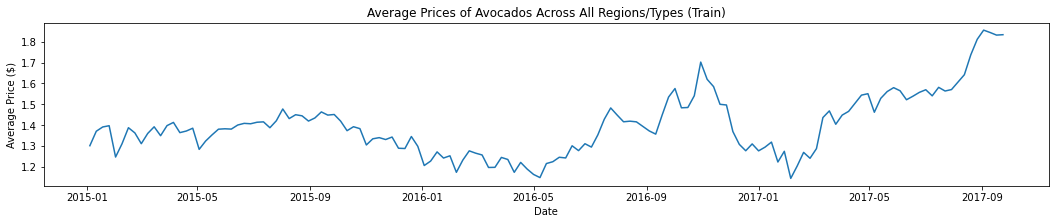

In [20]:
grouped = df_train.groupby(df_train.Date)
means = grouped.mean()
plt.rcParams["figure.figsize"] = (18,3)
plt.plot(means.index, means.AveragePrice);
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.title('Average Prices of Avocados Across All Regions/Types (Train)');

##### Simplify Preprocessing

In [21]:
numeric_features = ['AveragePrice', 'Total Volume', '4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year']
categorical_features = ['type', 'region']
drop_features = ['Date', 'Total Bags','AveragePriceNextWeek']

def preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features): # Adapted from Lecture 17

    all_features = set(numeric_features + categorical_features + drop_features)
    if set(df_train.columns) != all_features:
        print("Missing columns", set(df_train.columns) - all_features)
        print("Extra columns", all_features - set(df_train.columns))
        raise Exception("Columns do not match")
    
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])  
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='?')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])
    preprocessor.fit(df_train);

    ohe = preprocessor.named_transformers_['categorical'].named_steps['onehot']
    ohe_feature_names = list(ohe.get_feature_names(categorical_features))
    new_columns = numeric_features + ohe_feature_names

    X_train_enc = pd.DataFrame(preprocessor.transform(df_train).toarray(), index=df_train.index, columns=new_columns)
    X_test_enc  = pd.DataFrame(preprocessor.transform(df_test).toarray(),  index=df_test.index,  columns=new_columns)
    
    y_train = df_train["AveragePriceNextWeek"]
    y_test  = df_test["AveragePriceNextWeek"]
    
    return X_train_enc, y_train, X_test_enc, y_test, preprocessor

#### Answer:

In all models, I have dropped:
- `Date` because it should be encoded in some way
- `Total Bags` because this is redundant given info on bags of various sizes
- `AveragePriceNextWeek` because this is the target

##### Baseline: Ignoring Date

In [22]:
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features, categorical_features, drop_features)
X_train_enc.tail(3)

,AveragePrice,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_conventional,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18222,2.106988,-0.243716,-0.230516,-0.243611,-0.215395,-0.234741,-0.225423,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [23]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
validation_score = cross_validate(lr_pipe, df_train, y_train, cv=TimeSeriesSplit())['test_score'].mean()
lr_pipe.fit(df_train, y_train)
test_score = lr_pipe.score(df_test, y_test)
print(f'Mean Validation Score: {validation_score}')
print(f'Mean Test Score: {test_score}')

Mean Validation Score: 0.8225540106069082
Mean Test Score: 0.7881088378418357


##### Model 1: Count Days since Start
This is a most basic encoding, and I don't believe it will be very effective in capturing seasonality because it has no intuition on it.

In [24]:
# Adapted from Lecture 17
first_day = df_train["Date"].min()
df_train = df_train.assign(Days_since=df_train["Date"].apply(lambda x: (x-first_day).days))
df_test = df_test.assign(Days_since=df_test["Date"].apply(lambda x: (x-first_day).days))
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features + ['Days_since'], categorical_features, drop_features)
X_train_enc.tail(3)

,AveragePrice,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,Days_since,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,1.671739,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,1.695965,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18222,2.106988,-0.243716,-0.230516,-0.243611,-0.215395,-0.234741,-0.225423,-0.172063,1.376692,1.720191,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [25]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
validation_score = cross_validate(lr_pipe, df_train, y_train, cv=TimeSeriesSplit())['test_score'].mean()
lr_pipe.fit(df_train, y_train)
test_score = lr_pipe.score(df_test, y_test)
print(f'Mean Validation Score: {validation_score}')
print(f'Mean Test Score: {test_score}')

Mean Validation Score: 0.8217421239710501
Mean Test Score: 0.7838145912524138


##### 🌟 Model 2: One-hot Encoding Month 🌟
I believe this to be the best approach, because it gives the model intuition on seasonality by month.

In [26]:
# Adapted from Lecture 17
df_train = df_train.assign(Month=df_train["Date"].apply(lambda x: x.month))
df_test  = df_test.assign(Month=df_test[ "Date"].apply(lambda x: x.month))
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features, categorical_features + ['Month'], drop_features + ['Days_since'])
X_train_enc.tail(3)

,AveragePrice,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_conventional,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18222,2.106988,-0.243716,-0.230516,-0.243611,-0.215395,-0.234741,-0.225423,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [27]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
validation_score = cross_validate(lr_pipe, df_train, y_train, cv=TimeSeriesSplit())['test_score'].mean()
lr_pipe.fit(df_train, y_train)
test_score = lr_pipe.score(df_test, y_test)
print(f'Mean Validation Score: {validation_score}')
print(f'Mean Test Score: {test_score}')

Mean Validation Score: 0.8249737581276546
Mean Test Score: 0.800275013676964


In [28]:
# Ignore for now: this is to compare predicted and actual values later as this is the chosen model
test_results = df_test.copy()
test_results['PredictedAveragePriceNextWeek'] = lr_pipe.predict(df_test)
train_results = df_train.copy()
train_results['PredictedAveragePriceNextWeek'] = lr_pipe.predict(df_train)
coefficients = pd.DataFrame(data=lr_pipe[1].coef_, columns=['Coefficient'])
coefficients['Feature'] = X_train_enc.columns
coefficients = coefficients.reindex(coefficients.Coefficient.abs().sort_values(ascending=False).index)
coefficients.index = range(len(X_train_enc.columns))

##### Model 3: One-hot Encoding Season
I believe this to be slightly worse than the previous approach, because while there is some element of seasonality, the periodicity might be more granular than simply by season, so months provide a higher resolution.

In [29]:
def month_to_season(month):
    if (month == 12 or month == 1 or month == 2):
        return 'Winter'
    elif (month == 3 or month == 4 or month == 5):
        return 'Spring'
    elif (month == 6 or month == 7 or month == 8):
        return 'Summer'
    elif (month == 9 or month == 10 or month == 11):
        return 'Fall'

df_train['Season'] = [month_to_season(month) for month in df_train['Month']]
df_test['Season'] = [month_to_season(month) for month in df_test['Month']]
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features, categorical_features + ['Season'], drop_features + ['Month', 'Days_since'])
X_train_enc.tail(3)

,AveragePrice,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,type_conventional,...,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico,Season_Fall,Season_Spring,Season_Summer,Season_Winter
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
18222,2.106988,-0.243716,-0.230516,-0.243611,-0.215395,-0.234741,-0.225423,-0.172063,1.376692,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [30]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
validation_score = cross_validate(lr_pipe, df_train, y_train, cv=TimeSeriesSplit())['test_score'].mean()
lr_pipe.fit(df_train, y_train)
test_score = lr_pipe.score(df_test, y_test)
print(f'Mean Validation Score: {validation_score}')
print(f'Mean Test Score: {test_score}')

Mean Validation Score: 0.8225295074080187
Mean Test Score: 0.793905881803112


##### Model 4: Periodic Encoding

Assuming we know avocado prices have an element of periodicity that is annual, we can try to use periodic encoding like we did in lecture. From our initial plot, we can sort of see prices increasing towards the end of the year, so this could be a valuable assumption.

In [31]:
# Adapted from Lecture 17
df_train = df_train.assign(Month_sin = np.sin(2*np.pi*df_train["Month"]/12))
df_train = df_train.assign(Month_cos = np.cos(2*np.pi*df_train["Month"]/12))
df_test = df_test.assign(Month_sin = np.sin(2*np.pi*df_test["Month"]/12))
df_test = df_test.assign(Month_cos = np.cos(2*np.pi*df_test["Month"]/12))
X_train_enc, y_train, X_test_enc, y_test, preprocessor = preprocess_features(df_train, df_test, numeric_features + ['Month_sin', 'Month_cos'], categorical_features, drop_features + ['Month', 'Season', 'Days_since'])
X_train_enc.tail(3)

,AveragePrice,Total Volume,4046,4225,4770,Small Bags,Large Bags,XLarge Bags,year,Month_sin,...,region_SouthCarolina,region_SouthCentral,region_Southeast,region_Spokane,region_StLouis,region_Syracuse,region_Tampa,region_TotalUS,region_West,region_WestTexNewMexico
18220,2.400008,-0.243034,-0.230503,-0.241696,-0.215395,-0.234745,-0.225499,-0.172063,1.376692,-1.46177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18221,2.351171,-0.243442,-0.230278,-0.243130,-0.215395,-0.234638,-0.225529,-0.172063,1.376692,-1.46177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
18222,2.106988,-0.243716,-0.230516,-0.243611,-0.215395,-0.234741,-0.225423,-0.172063,1.376692,-1.46177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [32]:
lr_pipe = make_pipeline(preprocessor, Ridge(max_iter=1000))
validation_score = cross_validate(lr_pipe, df_train, y_train, cv=TimeSeriesSplit())['test_score'].mean()
lr_pipe.fit(df_train, y_train)
test_score = lr_pipe.score(df_test, y_test)
print(f'Mean Validation Score: {validation_score}')
print(f'Mean Test Score: {test_score}')

Mean Validation Score: 0.8235128989635886
Mean Test Score: 0.7995171124265865


##### Discussion

The best approach was **Model 2: One-hot Encoding Month**, because it had the highest validation/test scores. I believe this is because it captures some element of seasonality, but it does so on a granular level, by making it easier for the model to discover in which months avocados tend to be less/more expensive.

#### 1(f)
rubric={points:3}

We talked a little bit about _seasonality_, which is the idea of a periodic component to the time series. For example, in lecture we attempted to capture this by encoding the month. Something we didn't discuss much is _trends_, which are long-term variations in the quantity of interest. Aside from the effects of climate change, the amount of rain in Australia is likely to vary during the year but less likely to have long-term trends over the years. Avocado prices, on the other hand, could easily exhibit trends: for example avocados may just cost more in 2020 than they did in 2015.

Briefly discuss in ~1 paragraph: to what extent, if any, was your model above able to account for seasonality? What about trends?

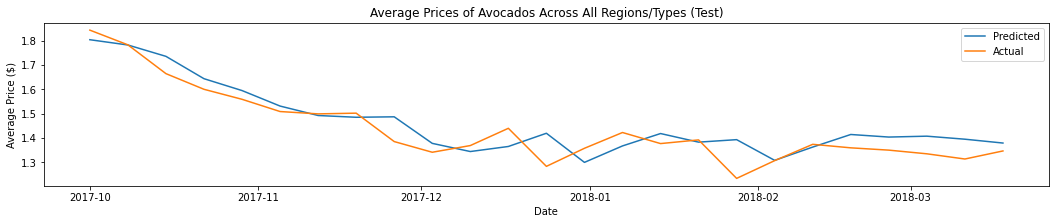

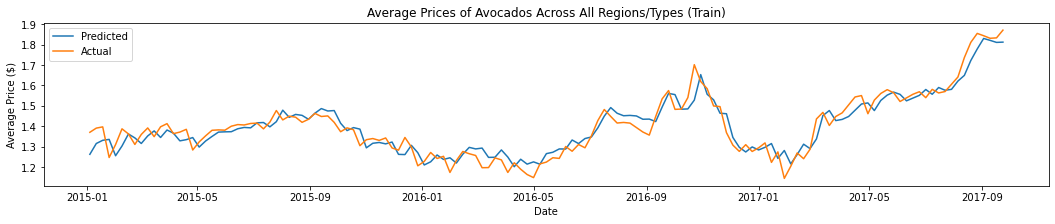

Rankings of Month_n Coefficients:
[12, 16, 23, 24, 37, 42, 49, 52, 55, 64, 67, 74]
Ranking of the Year Coeffient:
51
Most Important Feature:
Coefficient        0.316194
Feature        AveragePrice
Name: 0, dtype: object


In [33]:
grouped = test_results.groupby(test_results.Date)
means = grouped.mean()
plt.rcParams["figure.figsize"] = (18,3)
plt.plot(means.index, means.PredictedAveragePriceNextWeek, label='Predicted')
plt.plot(means.index, means.AveragePriceNextWeek, label='Actual')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.title('Average Prices of Avocados Across All Regions/Types (Test)');
plt.show()
grouped = train_results.groupby(train_results.Date)
means = grouped.mean()
plt.rcParams["figure.figsize"] = (18,3)
plt.plot(means.index, means.PredictedAveragePriceNextWeek, label='Predicted')
plt.plot(means.index, means.AveragePriceNextWeek, label='Actual')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price ($)')
plt.title('Average Prices of Avocados Across All Regions/Types (Train)');
plt.show()
print('Rankings of Month_n Coefficients:')
print(coefficients[coefficients.Feature.isin(['Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'])].index.to_list())
print('Ranking of the Year Coeffient:')
print(coefficients[coefficients.Feature == 'year']['Coefficient'].index[0])
print('Most Important Feature:')
print(coefficients.iloc[coefficients.Coefficient.argmax()])

#### Answer:

The chosen model (**Model 2: One-hot Encoding Month**) was able to account for seasonality to some extent, because it had some intuition on which month each observation was in due to the one-hot encoding, and these had varying degrees of influence over the model, as seen by the variation in how each month's coefficient ranked (compared to all features). This is more clear in the train graph (which could be due to overfitting), where the predicted values mimic the shape of the actual values in each part of the year. It was also able to account for trends to some extent, because it had information on the `year` (in addition to the month), which ranked 51 out of all 77 coefficients. This is more clear in the test graph, where we see the predicted values follow a similar downward trend as the actual values. However, there were many more heavily weighted features, especially `AveragePrice` which also contribute to how well the predicted values align with the actual.

## Exercise 2: very short answer questions

Each question is worth 2 points.

#### 2(a)
rubric={points:4}

The following questions pertain to Lecture 17 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

#### Answer:
1. Natural disasters such as earthquakes or tsunamis will generally have unequally spaced time points, because they might not occur for many years, and then occur at arbitrary points in time in clusters (triggered by one another).
2. Both; creating lagged versions of features will suffer because if previous rows are used as features, the lag will be unequal, making it difficult for the model to extract a meaningful pattern. Encoding the date could also struggle because there will be large gaps in the encoding for which no data exists, preventing the model from capturing more detailed trends.

#### 2(b)
rubric={points:6}

The following questions pertain to Lecture 18 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

#### Answer:
1. We want to predict time until churn, or whether a churn will happen in a given period, but we don't have access to when churns happened for all values, because some individuals have yet to churn; meaning we don't have correct target values. Using only true churners or assuming all have churned will lead to underestimates, so we have to use survival analysis to estimate this.
2. We don't have enough information because we need the survival functions of each customer; if A's curve is close to horizontally flat for at least a week while B's has a steep negative slope for at least a year, we would expect B to leave first given the lower probability. If A's curve is vertically flat (steep negative) for the first week and B's curve is close to horizontally flat for a year, we would expect A to leave first given the lower probability.
3. If survival probability decreases over time, a near flat *vertical* means probability of survival (not churning) rapidly decreases during that time period. If the survival function is a near flat *horizontal*, it means the probability of survival decreases slowly, if at all, over the given period.

## Submission to Canvas

**IF YOU ARE WORKING WITH A PARTNER** please form the group before submitting - see instructions [here](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md#partners).

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`.
2. Save your notebook.
3. Convert your notebook to `.html` format using the `convert_notebook()` function below **or** by `File -> Export Notebook As... -> Export Notebook to HTML`.
4. Run the code `submit()` below to go through an interactive submission process to Canvas.
>For this step, you will need a Canvas *Access Token* token. If you haven't already got one, log-in to Canvas, click `Account` (top-left of the screen), then `Settings`, then scroll down until you see the `+ New Access Token` button. Click that button, give your token any name you like and set the expiry date to Dec 31, 2020. Then click `Generate token`. Save this token in a safe place on your computer as you'll need it for all assignments. Treat the token with as much care as you would an important password. 

Note: for those having trouble with the Jupyter widgets and the dropdowns: if you add the argument `no_widgets=True` to your `submit` call, it should let you do a text-based entry of your key and avoid the dropdowns altogether. If this doesn't work, you probably need to upgrade to the latest version of `canvasutils` with `pip install canvasutils -U` from your terminal with your environment activated.


In [34]:
from canvasutils.submit import submit, convert_notebook

# Note: the canvasutils package should have been installed as part of your environment setup - 
# see https://github.com/UBC-CS/cpsc330/blob/master/docs/setup.md

In [37]:
# convert_notebook("hw7.ipynb", "html")  # uncomment and run when you want to try convert your notebook to HTML (or you can convert manually from the File menu)

Notebook successfully converted! 


In [38]:
# submit(course_code=53561, token=False)  # uncomment and run when ready to submit 

Please paste your token here and then hit enter:


 ······································································



Token successfully entered - thanks!


Select an assignment to submit to:


Output()